<a href="https://colab.research.google.com/github/vlr112/WebScicence_FinalProject/blob/main/Copy_of_parse_and_clean_meta_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import gzip
import numpy as np

from pandas.util import hash_pandas_object

from collections import namedtuple

# #######
# # import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# import surprise
# import regex as re

In [2]:
# So I don't need to always write "print"
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Familiarize Yourself with the Datasets

## Ex.1
Download and import the dataset.

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')
  # return pd.DataFrame.from_dict(df)


df_software = getDF('Software_5.json.gz')



In [4]:

class Data:

  def __init__(self,df):

    self.df = df

  def remove_duplicates(self):

    """ Clean the dataset from missing ratings and duplicates (cases where the
        same user has rated the same item multiple times) if any."""

    df_clean = self.df[self.df['overall'].notna()]
    df_clean = df_clean.sort_values(by =['reviewerID', 'asin', 'unixReviewTime'])
    df_clean = df_clean.drop_duplicates(subset = ['reviewerID', 'asin', ], keep = 'last')
    return df_clean.sort_values(by= ['reviewerID', 'unixReviewTime'])


  def pre_test(self):

    """ Create a 'pre'-test dataframe set by extracting the latest positively rated item (rating ≥ 4)
        by each user."""
        
    df_clean = self.remove_duplicates()
    positive_rating = df_clean[df_clean['overall'] >= 4.0]

    #sort_it by unixReviewTime and keep most recent
    sorted = positive_rating.drop_duplicates(subset=['reviewerID'],keep= 'last')
    return sorted


  def get_train(self):

    """ Create train dataframe from cleaned rows not present in 'pre'-test dataframe"""

    df_clean = self.remove_duplicates()
    pre_test = self.pre_test()
    train = df_clean[~df_clean.index.isin(pre_test.index)]
    return train


  def get_test(self):

    """ Remove users from 'pre'-test that do not appear in the training set"""

    pre_test = self.pre_test()
    train = self.get_train()
    test = pre_test[pre_test.reviewerID.isin(train.reviewerID)]   
    return test



In [5]:
# Instantiate Class

software = Data(df_software)
pre_test = software.pre_test()
train = software.get_train()
test = software.get_test()



##Ex.2
Clean the dataset from missing ratings and duplicates (cases where the same user has rated the same item multiple times) if any.

in class

## Ex.3 
Later in the project, we will evaluate different recommender systems on
the task of recommending the next item a user will like. For that purpose,
create a test set by extracting the latest positively rated item (rating ≥ 4)
by each user. Remove users that do not appear in the training set.



In [6]:
print('length train set is : ', len(train)) 
print('length test set is : ', len(test)) 

length train set is :  10171
length test set is :  1711


## Ex.4 
Compute user and item statistics (such as distribution of ratings per
user/item, the top 5 most popular items) for the training set and write
a discussion; does the dataset have important properties that should be
taken into account or that may mislead the evaluation?

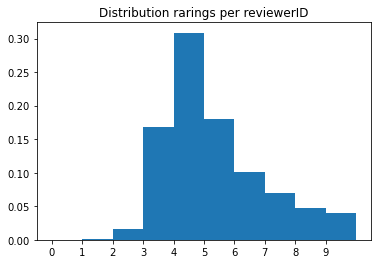

,overall
count,1824.000000
mean,5.576206
std,3.488828
min,1.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,51.000000


In [7]:

def plot_dist(df,ff):

  ba = df.groupby(ff).agg({'overall': 'count'}).reset_index().drop(ff, axis = 1)
  plt.hist(ba['overall'], weights=np.ones(len(ba['overall'])) / len(ba['overall']), bins = range(11))
  plt.xticks(range(10))
  plt.title(f'Distribution rarings per {ff}')
  plt.show()
  return ba.describe()

plot_dist(train,'reviewerID')



In [8]:
# plot_dist(train,'asin')

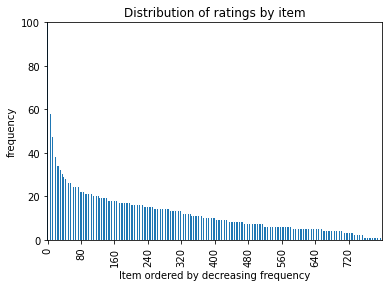

count    800.000000
mean      12.713750
std       16.234801
min        1.000000
25%        5.000000
50%        9.500000
75%       17.000000
max      226.000000
Name: counts, dtype: float64

In [9]:
def ex4_2(train):

    # Count occurences per item 
    s = pd.Series(train['asin'].value_counts(), name='counts')

    tr = (s.to_frame())

    #new column for ranking. to make a axis
    tr['index'] = tr.rank(ascending=False, method='first')

    tr['counts'].plot(kind = 'bar', xticks=tr['index'] )
    plt.xticks(range(800))
    plt.locator_params(axis='x', nbins=10)

    plt.ylabel("frequency")
    plt.xlabel("Item ordered by decreasing frequency")
    plt.ylim(0, 100)

    plt.title('Distribution of ratings by item')

    plt.show()

    return tr['counts'].describe()

ex4_2(train)

In [10]:
#MUST CHECK
# the top 5 most popular items
# display(train_set)


def top5(df):
  top_df = df.groupby('asin').mean().reset_index()
  top_df = top_df.sort_values(by = ['overall'], ascending = False)
  return top_df['asin'].head(5)

top5_ratings = top5(train)

(top5_ratings)


214    B0015CA9VW
217    B0015T5Q86
213    B0014ZQMXO
206    B0014A2LJ8
191    B0013MCZRK
Name: asin, dtype: object

## Ex.5 
The metadata file contains information of all items in the complete dataset,
not only the 5-core subset. You need to filter out all items that are not
included in the training and/or test sets after steps (2) and (3).

In [11]:
# access items in df 5_core

items_train = train['asin']#.unique()
items_test = test['asin']#.unique()

len(items_train)

items = pd.DataFrame(np.concatenate((items_train, items_test)))[0].unique()

len(items) 

10171

801

In [12]:
meta_df_software = getDF('meta_Software.json.gz')

meta_df_software['asin'].nunique()

21639

In [13]:
def clean_meta(df):

    """Takes metadata dataframe and remove duplicated rows"""

    df_clean = df[df['asin'].notna()]
    df_clean = df.sort_values(by =[ 'asin'])
    
    # in case i want to check duplicates
    # df_clean[df_clean.duplicated(subset = ['asin'], keep = False)]

    df_clean = df.drop_duplicates(subset = [ 'asin' ], keep = 'first')

    return df_clean

software_meta_unique = clean_meta(meta_df_software)

# filter out all items that are not included in the training and/or test sets after steps (2) and (3).
temp = software_meta_unique[software_meta_unique.asin.isin(items)]


#  Collaborative Filtering Recommender System


## Ex.1
Define a neighborhood-based and a latent factor model that uses the observed
user-item ratings in the training set to predict the unobserved ratings.
Report your choice of models.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from surprise import Reader
from surprise import Dataset


import surprise 

from pandas.io.parsers.readers import read_csv
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

from  surprise import KNNWithMeans
from surprise import SVD

For neigborhood-based CF i choose item-based CF 

similarity measures to test: msd, cosine, pearson
....

number of neignors: 1, ..., 19
...

## ITEM BASED CF

In [15]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

# Return a list of ratings that can be used as a testset in the test() method.
# The ratings are all the ratings that are not in the trainset, i.e. all the ratings rui where the user u is known, the item i is known, but the rating rui is not in the trainset. 
anti_test = trainset.build_anti_testset()

In [16]:
# train.head()

In [17]:
#ITEM BASED MODEL

param_grid_neigh = {'k': list(range(1,20)),
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
                              # 'min_support': [1,2,3,4,5],
                              'user_based': [False]},
                'verbose': [False]
              }

gs_neigh = GridSearchCV(KNNWithMeans, param_grid_neigh, measures=['rmse'], cv=3)

gs_neigh.fit(data)

# best RMSE score
print(gs_neigh.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_neigh.best_params['rmse'])

best_k = gs_neigh.best_params['rmse']['k']
best_sim =  gs_neigh.best_params['rmse']['sim_options']['name']

1.3062576865832582
{'k': 6, 'sim_options': {'name': 'cosine', 'user_based': False}, 'verbose': False}


In [18]:
print('Optimal Parameters for item-based:')
print('k: ', best_k )
print('similarity measure: ', best_sim)

print('average RMSE over 3 fold cross validation: ', gs_neigh.best_score['rmse'] )

Optimal Parameters for item-based:
k:  6
similarity measure:  cosine
average RMSE over 3 fold cross validation:  1.3062576865832582


In [19]:

# Run the models with the optimal hyperparameters to the whole training set.

sim_options= {'k': best_k,
              'name': best_sim,
            #   'min_support': [1, 5],
              'user_based': [False]}


alg_nbm = KNNWithMeans(sim_options= sim_options, random_state = 0, verbose = True)

# nbm -> neigborhood based model
predictions_nbm = alg_nbm.fit(trainset).test(anti_test)

print('Number of predictions: ',len(predictions_nbm) )

Computing the cosine similarity matrix...
Done computing similarity matrix.
Number of predictions:  1449029


In [20]:
pred_nbm_df = pd.DataFrame(predictions_nbm)
pred_nbm_df
np.mean(pred_nbm_df['est'])

,uid,iid,r_ui,est,details
0,A100UD67AHFODS,B000UJUJ7U,3.745453,5.0,"{'actual_k': 0, 'was_impossible': False}"
1,A100UD67AHFODS,B0013O54OE,3.745453,5.0,"{'actual_k': 0, 'was_impossible': False}"
2,A100UD67AHFODS,B001AFFZM2,3.745453,5.0,"{'actual_k': 0, 'was_impossible': False}"
3,A100UD67AHFODS,B001EJQTUG,3.745453,5.0,"{'actual_k': 0, 'was_impossible': False}"
4,A100UD67AHFODS,B001UO8M8M,3.745453,5.0,"{'actual_k': 0, 'was_impossible': False}"
...,...,...,...,...,...
1449024,AZZ5ASC403N74,B00113N12E,3.745453,4.0,"{'actual_k': 0, 'was_impossible': False}"
1449025,AZZ5ASC403N74,B0013YFI68,3.745453,4.0,"{'actual_k': 0, 'was_impossible': False}"
1449026,AZZ5ASC403N74,B0011DM0IA,3.745453,4.0,"{'actual_k': 0, 'was_impossible': False}"
1449027,AZZ5ASC403N74,B000XS9YJW,3.745453,4.0,"{'actual_k': 0, 'was_impossible': False}"


3.7905739170685564

## Latent Factor Model

In [21]:
param_grid_lat = {'n_epochs': [50, 100, 150],
              'n_factors' : [ 6, 10, 15],
            #   'lr_all': [0.005],
              'reg_all':[0.1],
              'random_state': [0],
              'verbose' : [False]}

gs_lat = GridSearchCV(SVD, param_grid_lat, measures=['rmse'], cv=3, n_jobs=5)

gs_lat.fit(data)

# best RMSE score
print(gs_lat.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_lat.best_params['rmse'])

# best_k_lat = gs_lat.best_params['rmse']['k']
# best_sim_lat =  gs_lat.best_params['rmse']['sim_options']['name']

1.1235532990219406
{'n_epochs': 100, 'n_factors': 6, 'reg_all': 0.1, 'random_state': 0, 'verbose': False}


In [22]:
gs_lat.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x24cc4fdf970>}

In [23]:
# alg_svd = SVD( gs_lat.best_params,  random_state= 0, verbose = False)

alg_svd = gs_lat.best_estimator['rmse']
#mdm -> model based model
predictions_mbm = alg_svd.fit(trainset).test(anti_test)


In [24]:
pred_mbm_df = pd.DataFrame(predictions_mbm)
np.mean(pred_mbm_df['est'])

3.6665588338462576

# Evaluation of Recommender Systems

In this session, we will discuss how to evaluate a recommender system. Specifically, let us evaluate your Collaborative Filtering (CF) models on the test data split defined in Week 6. You need to:

• Measure the error of the system’s predicted ratings for Software products
(Root Mean Square Error, RMSE).

• Discuss the limitations of this metric.

In [25]:
#dataframe with users in train that are not in test dataset.
re = train[~train.reviewerID.isin(test.reviewerID)]

# # Remove these users' predictions for evaluation
upd_pred_mbm_df = pred_mbm_df[pred_mbm_df.uid.isin(test.reviewerID)]
upd_pred_nbm_df = pred_nbm_df[pred_nbm_df.uid.isin(test.reviewerID)]


print('Working with {} users and {} items. '.format(len(test['reviewerID'].value_counts()), len(test['asin'].value_counts())))
print('There are {} users in training set that are not in the test set. '.format(len(re['reviewerID'].value_counts())))
print('Evaluating the systems with {} predictions for users in the test split.'.format(len(upd_pred_nbm_df)))


# determine RMSE of cleaned predictions dataframe
#1st must pass df to list of lists

rmse_mbm =surprise.accuracy.rmse(upd_pred_mbm_df.values.tolist(), verbose=False)
rmse_nbm =surprise.accuracy.rmse(upd_pred_nbm_df.values.tolist(), verbose=False)



print('RMSE for Neighborhood based Collaborative Filtering: {}'.format(rmse_nbm) )

print('RMSE for Latent Factor based Collaborative Filtering: {}'.format(rmse_mbm) )

Working with 1711 users and 465 items. 
There are 113 users in training set that are not in the test set. 
Evaluating the systems with 1359246 predictions for users in the test split.
RMSE for Neighborhood based Collaborative Filtering: 1.0459754888416675
RMSE for Latent Factor based Collaborative Filtering: 0.7960555583899309


DISCUSSION: Discuss the limitations of this metric.


In [26]:
class Metrics0:

  def __init__(self,df,test,k):

    self.df = df
    self.test = test
    self.k = k

  def prepare(self):
    """ Join prediction df with test df so the final df has at the ground truth (in this case there's just 1 GT per user)"""

    # upd_pred_nbm_df = top_rec(upd_pred_nbm_df, 10)
    # get r_ui column all to zeros
    upd_pred_nbm_df = self.df.assign(r_ui=0)

    #prepare test df for merging
    new_test = self.test[['reviewerID', 'asin', 'overall']]
    new_column_list = ['uid', 'iid', 'r_ui']
    new_test = new_test.set_axis(new_column_list, axis=1)

    #concat predictions df with test df
    joint = pd.concat([upd_pred_nbm_df, new_test]).sort_values(by = ['uid', 'iid'])

    #make df with just duplicates
    duplies = joint[joint.duplicated(subset = ['uid', 'iid'], keep= False)].sort_values(by=['uid', 'r_ui'])

    #shift up by 1, so the predictions rows have the real value
    duplies['r_ui'] = duplies['r_ui'].shift(-1)

    #drop test rows. They no longer matter
    no_duplies = duplies[duplies['est'].notna()]


    final = pd.concat([joint, no_duplies]).sort_values(by = ['uid', 'iid', 'r_ui']).drop_duplicates(['uid', 'iid'], keep = 'last')#.reset_index(drop=True)
    final = final.sort_index(axis = 0)
    final = final.sort_values(by= ['uid', 'est'], ascending= False)

    #make new column with row index by group
    final['group_index'] = final.groupby('uid').cumcount()+1

    return final


  def get_top_k(self):
    final = self.prepare()
    tt = final.groupby(['uid']).head(self.k)
    return tt


  def get_precision(self):

    final = self.prepare()
    tt = final.groupby(['uid']).head(self.k)

    gg = tt.groupby(['uid']).agg(lambda x: x.ne(0).sum())

    return np.mean(gg['r_ui']/self.k)
    # return gg


  
  def hit_rate(self):
    """ Difference from Precision@k is: at the end 
    -> we have count of non-zeros 'r_ui' per user. (Note: in this exercicise we get AT MOST 1 count per user, because of initial building of test dataset, with just 1 item per user).
    -> calculate mean over all users.
    In Precision@k:
    -> .... same
    -> divide the count of non-zeros for a given user by k. 
    -> caluclate mean over all users  """
    
    final = self.prepare()

    # Select only top k rows for each user
    tt = final.groupby(['uid']).head(self.k)

    # Count number of non-zero elements PER USER. It returns df with many columns (only 'r_ui' matters to us)
    gg = tt.groupby(['uid']).agg(lambda x: x.ne(0).sum())

    return np.mean(gg['r_ui'])
    

  def get_MRR(self):

    final = self.prepare()

    final = final.groupby(['uid']).head(self.k)
    final = final[final['r_ui'].apply(lambda x: x != 0)]
    return (sum(1/final['group_index']))/ len(self.test)


  def get_MAP(self):
    
    df = self.prepare()

    df = df.groupby(['uid']).head(self.k)

    #make new column with row index by group
    # df['group_index'] = df.groupby('uid').cumcount()

    # get rows index that matter to calculate MAP@k
    df_new = df[df['r_ui'].apply(lambda x: x != 0)]

    return sum(1/(df_new['group_index']))/len(self.test)

    # return df

In [27]:
item_based = Metrics0(upd_pred_nbm_df, test, 5)
item_based.get_precision()
item_based.get_MAP()
item_based.get_MRR()

# hola.hit_rate()

0.0015195791934541204

0.0037210208455094483

0.0037210208455094483

In [28]:
svd = Metrics0(upd_pred_mbm_df, test, 5)
svd.get_precision()
svd.get_MAP()
svd.get_MRR()


0.0005844535359438924

0.0012565751022793688

0.0012565751022793688

Discussion: advantages disavantages??

• Compute the system’s hit rate averaged over the total number of users in
the test set.

In [29]:
item_based.hit_rate()
svd.hit_rate()

0.007597895967270602

0.0029222676797194622

Error Analysis for the neighborhood-based CF:

• Ordered by the value of the column “unixReviewTime”, take the first
and last users from the test set as reference and retrieve the 10 nearest
neighbours of each reference user. Print their rate history and analyse
their predictions.

In [30]:
# time_sorted = test.sort_values(by = ['unixReviewTime'])

# first_user = time_sorted.iloc[[0]]

# last_user = time_sorted.iloc[[-1]]

#  Text Representation

## Preprocess

In [31]:
import os
import sys
sys.path.append('../')
import pickle
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

import regex as re
import nltk
# nltk.download()
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from nltk.lm import Vocabulary

import itertools
import string

from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import string

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
import texthero as hero
from texthero import preprocessing
import seaborn as sns

In [33]:
def hero_preprocess(temp):

    meta_pre_cleaned = temp.copy()

    custom_pipeline = [preprocessing.fillna,
                    preprocessing.lowercase,
                    
                    preprocessing.remove_diacritics,
                    preprocessing.remove_stopwords,
                    preprocessing.remove_punctuation,
                    preprocessing.remove_whitespace
                    #preprocessing.remove_brackets
                    ]

    meta_pre_cleaned['clean_text'] = hero.clean(meta_pre_cleaned['title'], custom_pipeline)
    # temp['clean_text'] = [n.replace('{','') for n in temp['clean_text']]
    # temp['clean_text'] = [n.replace('}','') for n in temp['clean_text']]
    # temp['clean_text'] = [n.replace('(','') for n in temp['clean_text']]
    # temp['clean_text'] = [n.replace(')','') for n in temp['clean_text']]

    return meta_pre_cleaned.reset_index()#.drop(['also_view', 'date', 'tech1', 'tech2', 'imageURL', 'imageURLHighRes', 'details'], axis = 1)

preprocessed = hero_preprocess(temp)#['clean_text'].head(20)

In [34]:
preprocessed.head(3)

,index,category,tech1,description,fit,title,also_buy,tech2,brand,feature,...,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,clean_text
0,88,[],,[This complete training program from Adobe Pre...,,Learn Adobe Photoshop Lightroom 3 by Video,[],,Peach Pit Press,[],...,[],Software,,</div>,$24.99,0321700945,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,learn adobe photoshop lightroom 3 video
1,89,[],,[This complete training program from Adobe Pre...,,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[],,Peach Pit Press,[],...,[],Software,,</div>,$35.23,0321719816,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,learn adobe dreamweaver cs5 video core trainin...
2,90,[],,[This complete training program from Adobe Pre...,,Learn Adobe Flash Professional CS5 by Video: C...,[],,Peach Pit Press,[],...,[],Software,,</div>,,0321719824,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,learn adobe flash professional cs5 video core ...


## TF-IDF 

In [35]:
tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(preprocessed['clean_text'])
tfs_matrix = tfs.todense()

tfs_matrix.shape

# tfs.get_features_names()

tfs_df = pd.DataFrame(tfs_matrix, columns= tfidf.get_feature_names(), index= preprocessed['asin'])

tfs_df


(801, 778)

,000,06950,08,09,10,11,11a,12,13,14,...,x9,xi,xp,xpvistawin,year,years,youtube,yr,yrs,zonealarm
asin,,,,,,,,,,,,,,,,,,,,,
0321700945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
0321719816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
0321719824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
0763855553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.3124,0.0,0.0,0.0,0.0,0.0
0982697813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01F7RJHIQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
B01FFVDY9M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
B01H39M7ME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0


In [36]:
def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  # df.columns = pre_embe['title']
  # df.index = pre_embe['title']
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(df, cmap=cmap)

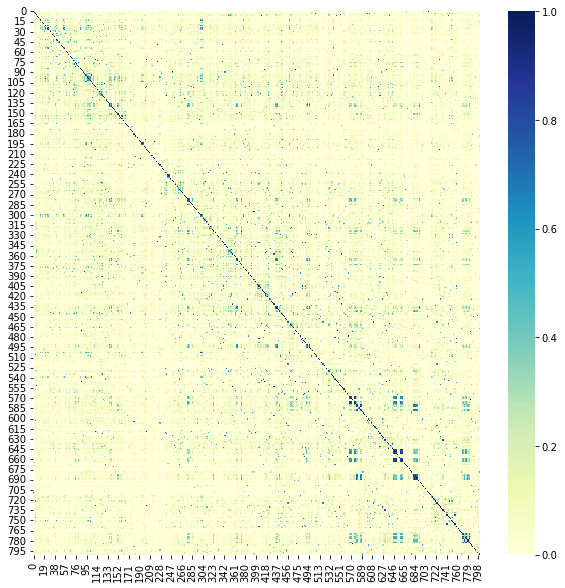

In [37]:
create_heatmap(cosine_similarity(tfs_matrix))

##  WORD2VEC WITH PRETRAINED MODEL. THEN AVERAGE TO GET PRODUCT VECTOR 

In [38]:
import gensim

In [39]:
# Load word2vec model (trained on an enormous Google corpus)
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True) 

# Check dimension of word vectors
model_word2vec.vector_size

300

In [40]:
main_data = temp.copy()

# Grab all the titles 
article_titles = main_data['title']

# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

In [41]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model_word2vec.vocab]
    return np.mean(model_word2vec[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [42]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

print(len(corpus))

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model_word2vec, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model_word2vec, doc))
    
X = np.array(x) # list to array

801
5 docs removed
0 docs removed


In [43]:
X

array([[ 0.10979004, -0.04043579, -0.1371582 , ..., -0.12961426,
        -0.0651001 ,  0.17050782],
       [ 0.00508118, -0.00793839, -0.04605103, ..., -0.06278992,
        -0.02516937,  0.03714752],
       [-0.01358643,  0.00346756, -0.04724121, ..., -0.04591065,
        -0.04468384,  0.01576538],
       ...,
       [ 0.16455078, -0.15551758, -0.1408081 , ..., -0.1875    ,
         0.05456161, -0.00878906],
       [ 0.0959961 ,  0.03847656,  0.00789795, ..., -0.11342774,
        -0.03813476,  0.03657227],
       [ 0.1046875 ,  0.0248291 ,  0.0003418 , ..., -0.11977539,
        -0.04619141,  0.04157715]], dtype=float32)

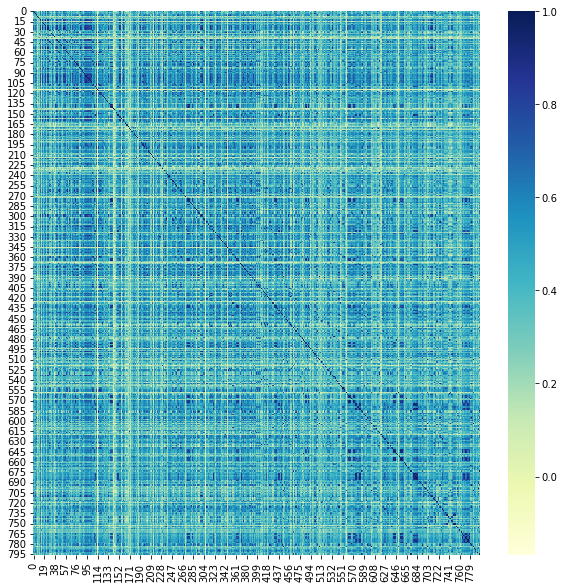

In [44]:


create_heatmap(cosine_similarity(X))

# Content-Based Recommender System

Transform the “title” column of each product into a TF-IDF score or other numerical value, e.g., token-count based, that can represent the summaries. Select other factors that can be used as product features.

In [45]:

#remove whitespaces in Brand names. So when we use Vectorizer, each brand is treated as one. 'Peach Pit Press' -> 'PeachPitPress' 
# preprocessed['brand'].str.replace(" ", "")

preprocessed['pre_feat'] = preprocessed['clean_text'] + ' ' + preprocessed['brand'].str.replace(" ", "") 

In [46]:
preprocessed.loc[preprocessed['brand'] == 'sonycreativesoftware']

# theneatcompany

preprocessed['brand'].nunique()

,index,category,tech1,description,fit,title,also_buy,tech2,brand,feature,...,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,clean_text,pre_feat


141

In [47]:
tfidf_cont = TfidfVectorizer()
tfs_cont = tfidf_cont.fit_transform(preprocessed['pre_feat'])
tfs_matrix_cont = tfs_cont.todense()

tfs_matrix_cont.shape


tfs_df_cont = pd.DataFrame(tfs_matrix_cont, columns= tfidf_cont.get_feature_names(), index= preprocessed['asin'])

# tfs_df['ImmersionDigital']

# zum_names = tfidf_cont.get_feature_names()

(801, 867)

After you represent each product in a vector space, represent each user in
the same vector space. This can be done by using an average of the items
the user rates. Instead of a simple average, a weighted average can be
used, where the weight is the rating for the item by the user. Note: the
user representations and item representations all have the same number
of dimensions.

In [48]:
# access items in df 5_core

#get users both in test and train
users = pd.DataFrame(np.concatenate((train['reviewerID'], test['reviewerID'])))[0].unique()

#how many users have the items
print('number of users loaded: ', len(users) )

number of users loaded:  1824


In [49]:
clean_software = software.remove_duplicates()
len(clean_software)
train_and_test = clean_software[clean_software.reviewerID.isin(users)]


11884

In [50]:
def user_item_matrix(df):

  df = df[['reviewerID', 'asin', 'overall']]

  all = df.pivot(*df.columns).fillna(0)

  return all

In [51]:
def get_user_vectors(tfidf_matrix_dense, meta_data):

    """ Multiply (users, items) * (items, features) -> (users, features)
    Then, divide by number of ratings per user to get Weighted mean of user vectors"""

    # get user_item_matrix. From Collaborative Filtering
    almost = user_item_matrix(train_and_test)

    #make sure columns (items) order is correct, before matrix multiplication
    almost = almost[list(meta_data['asin'])]

    almost_matrix = almost.to_numpy()

    #get number of rated items per user to use later in the weighted vectorization
    count = (almost != 0).astype(int).sum(axis=1) 
    # make df to later append
    count = pd.DataFrame((count), index = count.index)


    # Multiply(981,84) * (84, 402) -> (981, 402)
    user_vectors_matrix = np.dot(almost_matrix,tfidf_matrix_dense)

    user_vectors_df = pd.DataFrame(user_vectors_matrix, index = list(almost.index))

    # Append 'count' df 
    user_vectors_df['count98'] = count

    # for given user divide all features by count
    final = user_vectors_df.div(user_vectors_df['count98'], axis = 0).drop(columns = ['count98'])


    return final, user_vectors_matrix

represent each user in the same vector space. This can be done by using an average of the items the user rates.

In [52]:
df_int , uv = get_user_vectors(tfs_matrix_cont, temp)

In [53]:
df_int

,0,1,2,3,4,5,6,7,8,9,...,857,858,859,860,861,862,863,864,865,866
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.031907,0.092734,0.0,0.081539,0.000000,0.0,...,0.0,0.0,0.000000,0.099995,0.0,0.0,0.0,0.0,0.0,0.0
A1075X1Q4M3S78,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
A10C5CJK1YKGV0,0.0,0.0,0.0,0.0,0.000000,0.374038,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
A10CRW7XRJBJ2G,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZD8SMNGQI98O,0.0,0.0,0.0,0.0,0.000000,0.100648,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.147629,0.087830,0.0,0.0,0.0,0.0,0.0,0.0
AZQGJ5CEAJGXB,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.315518,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
AZW10G02DNJI4,0.0,0.0,0.0,0.0,0.339957,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
AZYJE40XW6MFG,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.276805,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Calculate the user-item rating for an item by using a similarity metric between the user and the item. A similarity metric such as cosine distance
or Euclidean distance can be used.

Report Precision@5, MAP@5, MRR@k and the hit rate using the test set.
Compare the results with the models from previous weeks.

In [54]:
# my_user = uv[0].shape
# my_item = tfs_matrix[0].T

predict_ratings = pd.DataFrame(cosine_similarity(uv, tfs_matrix_cont).T, columns = df_int.index, index = tfs_df_cont.index )

predict_ratings

,A100UD67AHFODS,A105S56ODHGJEK,A1075X1Q4M3S78,A10C5CJK1YKGV0,A10CRW7XRJBJ2G,A10EIJM2C94M14,A10G3LHNAK4GEH,A10G4BPT5MGBHY,A10GU5NVTA5I67,A10NC6ZVVMBHNH,...,AZ24FJKEJNSDX,AZ515FFZ7I2P7,AZ61PR2UGT3IP,AZ8NQPFR743F0,AZAIARFUW642T,AZD8SMNGQI98O,AZQGJ5CEAJGXB,AZW10G02DNJI4,AZYJE40XW6MFG,AZZ5ASC403N74
asin,,,,,,,,,,,,,,,,,,,,,
0321700945,0.000000,0.056635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.074455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0321719816,0.000000,0.017977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.023633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0321719824,0.014637,0.026067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.022356,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025998
0763855553,0.043061,0.221615,0.081137,0.024296,0.022837,0.134640,0.016104,0.126999,0.030352,0.115089,...,0.041598,0.088440,0.000000,0.158888,0.032471,0.065585,0.000000,0.042532,0.019500,0.679118
0982697813,0.000000,0.011084,0.000000,0.000000,0.000000,0.068501,0.000000,0.088869,0.000000,0.016246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127051,0.000000,0.488208,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01F7RJHIQ,0.029323,0.300065,0.305558,0.025964,0.018804,0.048278,0.052430,0.049996,0.005212,0.014240,...,0.019376,0.148152,0.021958,0.016087,0.000000,0.092846,0.010151,0.013986,0.012905,0.209054
B01FFVDY9M,0.039889,0.250595,0.016969,0.314462,0.069765,0.021566,0.063730,0.100798,0.028645,0.071080,...,0.188151,0.269565,0.017446,0.067406,0.030645,0.177423,0.000000,0.089261,0.008762,0.211067
B01H39M7ME,0.018665,0.002988,0.000000,0.000000,0.065741,0.019781,0.065122,0.019970,0.000000,0.000000,...,0.046807,0.014468,0.000000,0.032290,0.000000,0.032290,0.000000,0.036153,0.000000,0.018916


In [55]:
flat_predict_ratings = predict_ratings.stack().reset_index(name='est').rename(columns={'level_1':'uid'})

flat_predict_ratings= flat_predict_ratings.rename({'asin': 'iid'}, axis = 1)

In [65]:
flat_predict_ratings
# # Remove these users' predictions for evaluation
upd_flat_predict_ratings = flat_predict_ratings[flat_predict_ratings.uid.isin(test.reviewerID)]

upd_flat_predict_ratings = upd_flat_predict_ratings[['uid', 'iid', 'est']]

upd_flat_predict_ratings

,iid,uid,est
0,0321700945,A100UD67AHFODS,0.000000
1,0321700945,A105S56ODHGJEK,0.056635
2,0321700945,A1075X1Q4M3S78,0.000000
3,0321700945,A10C5CJK1YKGV0,0.000000
4,0321700945,A10CRW7XRJBJ2G,0.000000
...,...,...,...
1461019,B01HAP3NUG,AZD8SMNGQI98O,0.232211
1461020,B01HAP3NUG,AZQGJ5CEAJGXB,0.438665
1461021,B01HAP3NUG,AZW10G02DNJI4,0.035111
1461022,B01HAP3NUG,AZYJE40XW6MFG,0.239223


,uid,iid,est
0,A100UD67AHFODS,0321700945,0.000000
1,A105S56ODHGJEK,0321700945,0.056635
2,A1075X1Q4M3S78,0321700945,0.000000
3,A10C5CJK1YKGV0,0321700945,0.000000
4,A10CRW7XRJBJ2G,0321700945,0.000000
...,...,...,...
1461019,AZD8SMNGQI98O,B01HAP3NUG,0.232211
1461020,AZQGJ5CEAJGXB,B01HAP3NUG,0.438665
1461021,AZW10G02DNJI4,B01HAP3NUG,0.035111
1461022,AZYJE40XW6MFG,B01HAP3NUG,0.239223


In [66]:
content_based = Metrics0(upd_flat_predict_ratings, test, 5)
content_based.get_precision()
content_based.get_MAP()
content_based.get_MRR()
content_based.hit_rate()

content_based.prepare()

0.12343658679134807

0.350720826027664

0.350720826027664

0.6171829339567504

,uid,iid,est,r_ui,group_index
7295,AZZ5ASC403N74,0763855553,0.679118,0.0,1
911999,AZZ5ASC403N74,B009SPL2K0,0.611027,4.0,2
924767,AZZ5ASC403N74,B00B1TEIRU,0.561986,0.0,3
1094399,AZZ5ASC403N74,B00HV9IM58,0.558355,0.0,4
791615,AZZ5ASC403N74,B005O24CWG,0.518608,0.0,5
...,...,...,...,...,...
1382592,A100UD67AHFODS,B0158RGNR8,0.000000,0.0,797
1393536,A100UD67AHFODS,B015PIIF80,0.000000,0.0,798
1395360,A100UD67AHFODS,B015PIIGQ6,0.000000,0.0,799
1439136,A100UD67AHFODS,B01CS8RSIS,0.000000,0.0,800


# Hybrid Recommender System

Weighted strategy that re-ranks the items by combining the individual
rankings from the two models with some aggregate function such as the
sum, average, minimum or maximum.

In [59]:
# Contant-based has 1 more item than Collaborative Filtering!!! 

In [67]:
# content_results = content_based.prepare()

item_results = item_based.prepare()
content_results = content_based.prepare()

# item_results



In [87]:
#Change group_index col names so they don't overlap

item_results = item_results.rename({'group_index': 'group_index_item'}, axis=1)
content_results =content_results.rename({'group_index': 'group_index_content'}, axis=1)

,uid,iid,r_ui,est,group_index_item,group_index_content


In [106]:
from math import inf

In [98]:


new = pd.merge(content_results,item_results, how = 'left', left_on = ['uid', 'iid'], right_on = ['uid', 'iid'])
# item_results.merge(content_results[[]])

In [109]:
# new.loc[new['iid'] == 'B009SPL2K0']
new['group_index_content'].fillna(inf, inplace = True)

new['group_index_item'].fillna(inf, inplace = True)

In [110]:
new

,uid,iid,est_x,r_ui_x,group_index_content,r_ui_y,est_y,group_index_item
0,AZZ5ASC403N74,0763855553,0.679118,0.0,1,NaN,NaN,inf
1,AZZ5ASC403N74,B009SPL2K0,0.611027,4.0,2,4.0,4.006614,172.0
2,AZZ5ASC403N74,B00B1TEIRU,0.561986,0.0,3,0.0,3.800000,675.0
3,AZZ5ASC403N74,B00HV9IM58,0.558355,0.0,4,0.0,4.145455,156.0
4,AZZ5ASC403N74,B005O24CWG,0.518608,0.0,5,0.0,4.000000,535.0
...,...,...,...,...,...,...,...,...
1370506,A100UD67AHFODS,B0158RGNR8,0.000000,0.0,797,0.0,5.000000,358.0
1370507,A100UD67AHFODS,B015PIIF80,0.000000,0.0,798,0.0,5.000000,259.0
1370508,A100UD67AHFODS,B015PIIGQ6,0.000000,0.0,799,0.0,5.000000,634.0
1370509,A100UD67AHFODS,B01CS8RSIS,0.000000,0.0,800,0.0,5.000000,175.0


In [113]:
# now apply Reciprocal Rank Fusion (RRF)

def rrf(df,k):

    """ reciprocal rank fusion """
    df['rrf'] = 1/(k+df['group_index_content']) + 1/(k+df['group_index_item'])

    return df.sort_values(by = ['uid', 'rrf'], ascending = False)

er = rrf(new, 60)


er[['uid', 'iid', 'r_ui_x', 'rrf']]

    



,uid,iid,r_ui_x,rrf
38,AZZ5ASC403N74,B000X86ZAS,0.0,0.026230
19,AZZ5ASC403N74,B000Y7Y6IQ,0.0,0.025658
27,AZZ5ASC403N74,B000TME1K4,0.0,0.024877
16,AZZ5ASC403N74,B0064PFB9U,0.0,0.021534
1,AZZ5ASC403N74,B009SPL2K0,4.0,0.020439
...,...,...,...,...
1370473,A100UD67AHFODS,B00EZPXYP4,0.0,0.002483
1370448,A100UD67AHFODS,B00BKWXNDI,0.0,0.002467
1370467,A100UD67AHFODS,B00EOAS4UA,0.0,0.002427
1370497,A100UD67AHFODS,B011XO5JZM,0.0,0.002393


Switching strategy that uses the recommendations from the collaborative
filtering model for some users and the recommendations from the contentbased
model for other users chosen by a predefined condition.

0.0

3. Meta-level strategy where a level of one model is used as input to the other
model.

In [114]:
# Use output from content as input to item-based

predict_ratings

,A100UD67AHFODS,A105S56ODHGJEK,A1075X1Q4M3S78,A10C5CJK1YKGV0,A10CRW7XRJBJ2G,A10EIJM2C94M14,A10G3LHNAK4GEH,A10G4BPT5MGBHY,A10GU5NVTA5I67,A10NC6ZVVMBHNH,...,AZ24FJKEJNSDX,AZ515FFZ7I2P7,AZ61PR2UGT3IP,AZ8NQPFR743F0,AZAIARFUW642T,AZD8SMNGQI98O,AZQGJ5CEAJGXB,AZW10G02DNJI4,AZYJE40XW6MFG,AZZ5ASC403N74
asin,,,,,,,,,,,,,,,,,,,,,
0321700945,0.000000,0.056635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.074455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0321719816,0.000000,0.017977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.023633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0321719824,0.014637,0.026067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.022356,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025998
0763855553,0.043061,0.221615,0.081137,0.024296,0.022837,0.134640,0.016104,0.126999,0.030352,0.115089,...,0.041598,0.088440,0.000000,0.158888,0.032471,0.065585,0.000000,0.042532,0.019500,0.679118
0982697813,0.000000,0.011084,0.000000,0.000000,0.000000,0.068501,0.000000,0.088869,0.000000,0.016246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127051,0.000000,0.488208,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01F7RJHIQ,0.029323,0.300065,0.305558,0.025964,0.018804,0.048278,0.052430,0.049996,0.005212,0.014240,...,0.019376,0.148152,0.021958,0.016087,0.000000,0.092846,0.010151,0.013986,0.012905,0.209054
B01FFVDY9M,0.039889,0.250595,0.016969,0.314462,0.069765,0.021566,0.063730,0.100798,0.028645,0.071080,...,0.188151,0.269565,0.017446,0.067406,0.030645,0.177423,0.000000,0.089261,0.008762,0.211067
B01H39M7ME,0.018665,0.002988,0.000000,0.000000,0.065741,0.019781,0.065122,0.019970,0.000000,0.000000,...,0.046807,0.014468,0.000000,0.032290,0.000000,0.032290,0.000000,0.036153,0.000000,0.018916


In [116]:
tfs_df_cont

,000,06950,08,09,10,11,11a,12,13,14,...,xi,xp,xpvistawin,year,years,youtube,yr,yrs,zonealarm,zonelabs
asin,,,,,,,,,,,,,,,,,,,,,
0321700945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0321719816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0321719824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0763855553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.294048,0.0,0.0,0.0,0.0,0.0,0.0
0982697813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01F7RJHIQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
B01FFVDY9M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
B01H39M7ME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
